In [1]:
import pdfplumber
import pandas as pd
import re
import os

In [2]:
column_names = ["club",	"last_name", "first_name", "position", "base_salary", "guaranteed_compensation"]

positions = ["F", "M", "D", "F", "G"]

clubs = ['Atlanta United', 'Austin FC', 'Charlotte FC', 'Chicago Fire', 'Chivas USA',
         'Colorado Rapids', 'Columbus Crew', 'DC United', 'FC Cincinnati',
         'FC Dallas', 'Houston Dynamo', 'Inter Miami', 'LA Galaxy', 'Los Angeles FC',
         'Major League Soccer', 'Minnesota United', 'Montreal Impact',
         'Nashville SC', 'New England Revolution', 'New York City FC',
         'New York Red Bulls', 'Orlando City SC', 'Philadelphia Union',
         'Portland Timbers', 'Real Salt Lake', 'San Jose Earthquakes',
         'Seattle Sounders FC', 'Sporting Kansas City', 'St. Louis City SC',
         'Toronto FC', 'Vancouver Whitecaps', 'Pool']

club_abr = {
    'ATL': 'Atlanta United',
    'AUS': 'Austin FC',
    'CLT': 'Charlotte FC',
    'CHI': 'Chicago Fire',
    'CHV': 'Chivas USA',
    'COL': 'Colorado Rapids',
    'CLB': 'Columbus Crew',
    'DC': 'DC United',
    'CIN': 'FC Cincinnati',
    'DAL': 'FC Dallas',
    'HOU': 'Houston Dynamo',
    'MIA': 'Inter Miami',
    'LA': 'LA Galaxy',
    'LAFC': 'Los Angeles FC',
    'MLS': 'Major League Soccer',
    'MIN': 'Minnesota United',
    'MTL': 'Montreal Impact',
    'NSH': 'Nashville SC',
    'NE': 'New England Revolution',
    'NYCFC': 'New York City FC',
    'NYRB': 'New York Red Bulls',
    'ORL': 'Orlando City SC',
    'PHI': 'Philadelphia Union',
    'POR': 'Portland Timbers',
    'RSL': 'Real Salt Lake',
    'SJ': 'San Jose Earthquakes',
    'SEA': 'Seattle Sounders FC',
    'SKC': 'Sporting Kansas City',
    'STL': 'St. Louis City SC',
    'TOR': 'Toronto FC',
    'VAN': 'Vancouver Whitecaps',
    'Pool': 'Pool'
}

team_region_mapping = {
    'Atlanta United': 'Eastern',
    'Austin FC': 'Western',
    'Charlotte FC': 'Eastern',
    'Chicago Fire': 'Eastern',
    'Chivas USA': 'Western',
    'Colorado Rapids': 'Western',
    'Columbus Crew': 'Eastern',
    'DC United': 'Eastern',
    'FC Cincinnati': 'Eastern',
    'FC Dallas': 'Western',
    'Houston Dynamo': 'Western',
    'Inter Miami': 'Eastern',
    'LA Galaxy': 'Western',
    'Los Angeles FC': 'Western',
    'Major League Soccer': 'N/A',
    'Minnesota United': 'Western',
    'Montreal Impact': 'Eastern',
    'Nashville SC': 'Western',
    'New England Revolution': 'Eastern',
    'New York City FC': 'Eastern',
    'New York Red Bulls': 'Eastern',
    'Orlando City SC': 'Eastern',
    'Philadelphia Union': 'Eastern',
    'Portland Timbers': 'Western',
    'Real Salt Lake': 'Western',
    'San Jose Earthquakes': 'Western',
    'Seattle Sounders FC': 'Western',
    'Sporting Kansas City': 'Western',
    'St. Louis City SC': 'Western',
    'Toronto FC': 'Eastern',
    'Vancouver Whitecaps': 'Western',
    'Pool': 'N/A'
}

def combine_elements(source_list, index1, index2):
    out_str = source_list[index1] + source_list[index2]
    del source_list[index2]
    source_list[index1] = out_str
    return source_list
    

def get_best_match(entry, option_list=clubs):

    if entry is None:
        return None
    best_match = None
    match_distance = float('inf')

    for option in option_list:
        distance = calc_lev_distance(entry, option)
        

        if distance < match_distance:
            best_match = option
            match_distance = distance


    return best_match

def calc_lev_distance(string1, string2):
    try:
        m = len(string1)
        n = len(string2)
    except TypeError:
        return(string1)

    # Create a matrix of size (m+1)x(n+1) to store the distances
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column of the matrix
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Calculate the distances using dynamic programming
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if string1[i - 1] == string2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    # Return the Levenshtein distance between the two strings
    return dp[m][n]

In [3]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2018.pdf')
pages = pdf.pages
mls_salaries_2018_df = pd.DataFrame(columns=column_names)
for page in pdf.pages:
        table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 9})
        del table[:4]
        for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 0, 1)
            line = combine_elements(line, 4, 5)
            line = combine_elements(line, 5, 6)
            if len(line) != 6:
                line = combine_elements(line, 0, 1)
            # combines last 3 spaces to then split with $
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2018_df = pd.concat([mls_salaries_2018_df, new_line_df], ignore_index=True)
pdf.close()
# mls_salaries_2018_df["position"] = mls_salaries_2018_df["position"].str.extract(r'([A-Z])')
mls_salaries_2018_df.position = mls_salaries_2018_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2018_df["base_salary"] = pd.to_numeric(mls_salaries_2018_df["base_salary"])
mls_salaries_2018_df["guaranteed_compensation"] = pd.to_numeric(mls_salaries_2018_df["guaranteed_compensation"])
mls_salaries_2018_df["base_salary"] = mls_salaries_2018_df["base_salary"] / 100
mls_salaries_2018_df["guaranteed_compensation"] = mls_salaries_2018_df["guaranteed_compensation"] / 100
mls_salaries_2018_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,New York Red Bulls,Abang,Anatole,F,68927.00,68927.00
1,New York City FC,Abdul-Salaam,Saad,D,106480.00,120230.00
2,Columbus Crew,Abu,Mohammed,M,175008.00,181258.00
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,PhiladelphiaUnion,Accam,David,F,1250000.04,1250000.04
...,...,...,...,...,...,...
689,FC Dallas,Ziegler,Reto,D,750000.00,800000.00
690,LAFC,Zimmerman,Walker,D,235000.00,235000.00
691,Atlanta United,Zizzo,Sal,D,129999.96,129999.96
692,FC Dallas,Zobeck,Kyle,G,67500.00,67500.00


In [4]:
mls_salaries_2018_df.to_csv('data/mls_salaries/mls-salaries-2018.csv', index=False)

In [5]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2019.pdf')
pages = pdf.pages
mls_salaries_2019_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 5})
        if i == 0:
            del table[:1]
        for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 0, 1)

            # combines last 3 spaces to then split with $
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2019_df = pd.concat([mls_salaries_2019_df, new_line_df], ignore_index=True)
pdf.close()
# mls_salaries_2019_df["position"] = mls_salaries_2019_df["position"].str.extract(r'([A-Z])')
mls_salaries_2019_df.position = mls_salaries_2019_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2019_df["base_salary"] = pd.to_numeric(mls_salaries_2019_df["base_salary"])
mls_salaries_2019_df["guaranteed_compensation"] = pd.to_numeric(mls_salaries_2019_df["guaranteed_compensation"])
mls_salaries_2019_df["base_salary"] = mls_salaries_2019_df["base_salary"] / 100
mls_salaries_2019_df["guaranteed_compensation"] = mls_salaries_2019_df["guaranteed_compensation"] / 100
mls_salaries_2019_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,PhiladelphiaUnion,Aaronson,Brenden,F,70000.08,98309.48
1,Seattle Sounders FC,Abdul-Salaam,Saad,D,70250.04,70250.04
2,Colorado Rapids,Abubakar,Lalas,D,135000.00,144937.50
3,Columbus Crew,Accam,David,F,1010004.00,1137920.00
4,Colorado Rapids,Acosta,Kellyn,M,549999.96,664999.96
...,...,...,...,...,...,...
709,FC Dallas,Ziegler,Reto,D,820000.08,870000.08
710,LAFC,Zimmerman,Walker,D,600000.00,600000.00
711,FC Dallas,Zobeck,Kyle,G,70875.00,70875.00
712,LA Galaxy,Zubak,Ethan,F,75000.00,78125.00


In [6]:
mls_salaries_2019_df.to_csv('data/mls_salaries/mls-salaries-2019.csv', index=False)

In [7]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2020.pdf')
pages = pdf.pages
mls_salaries_2020_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
      table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 8})
        
      del table[:2]
      for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 2, 3)

            if len(line) == 7:
                  line = combine_elements(line, 2, 3)
            if len(line) == 5:
                  for pos in positions:
                        if line[2].endswith(pos):
                              line[2] = line[2][:-len(pos)]
                              line.insert(3, pos)
                              break

            # places player name in correct position
            player_name = line[:2]
            del line[:2]
            line.insert(1, player_name[0])
            line.insert(2, player_name[1])

            # combines last 3 spaces to then split with $
            if len(line) != 6:
                   line.insert(3, 'G')
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2020_df = pd.concat([mls_salaries_2020_df, new_line_df], ignore_index=True)
            
pdf.close()
mls_salaries_2020_df.position = mls_salaries_2020_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2020_df["position"] = mls_salaries_2020_df["position"].str.extract(r'([A-Z])')
mls_salaries_2020_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,PhiladelphiaUnion,Aaronson,Brenden,M,85000,103309
1,FC Cincinnati,Abdul-Salaam,Saad,D,81375,90042
2,DC United,Abu,Mohammed,M,81375,81375
3,Colorado Rapids,Abubakar,Lalas,D,145000,154937
4,Nashville SC,Accam,David,F,875000,1002916
...,...,...,...,...,...,...
773,New York RedBulls,,Kaku,M,850000,850000
774,Orlando City SC,,Robinho,M,198000,205500
775,Philadelphia Union,,Ilsinho,M,425000,476250
776,San Jose Earthquakes,,Judson,M,320000,325000


In [8]:
mls_salaries_2020_df.to_csv('data/mls_salaries/mls-salaries-2020.csv', index=False)

In [9]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2021.pdf')
pages = pdf.pages
mls_salaries_2021_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 8})
        if i == 0:
            del table[:2]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2021_df = pd.concat([mls_salaries_2021_df, new_line_df], ignore_index=True)
            
pdf.close()
# mls_salaries_2021_df["position"] = mls_salaries_2021_df["position"].str.extract(r'([A-Z])')
mls_salaries_2021_df.position = mls_salaries_2021_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2021_df["base_salary"] = mls_salaries_2021_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2021_df["guaranteed_compensation"] = mls_salaries_2021_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2021_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,Atlanta United,Adams,"Mohammed ""Mo""",M,121000.0,141000.0
1,Atlanta United,Ambrose,Mikey,D,81375.0,81375.0
2,Atlanta United,Araujo,Luiz,F,3600000.0,3941667.0
3,Atlanta United,Barco,Ezequiel,M,1875000.0,2358333.0
4,Atlanta United,Bauer,Josh,D,63547.0,63547.0
...,...,...,...,...,...,...
866,Vancouver Whitecaps,Sousa e Silva,Caio Alexandre,M,500000.0,539583.0
867,Vancouver Whitecaps,Teibert,Russell,M,350000.0,387500.0
868,Vancouver Whitecaps,Veselinovic,Ranko,D,360000.0,445500.0
869,Vancouver Whitecaps,Vite,Pedro,M,556000.0,609997.0


In [10]:
mls_salaries_2021_df.to_csv('data/mls_salaries/mls-salaries-2021.csv', index=False)

In [11]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2022.pdf')
pages = pdf.pages
mls_salaries_2022_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 9})
        if i == 0:
            del table[:1]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2022_df = pd.concat([mls_salaries_2022_df, new_line_df], ignore_index=True)
            
pdf.close()
# mls_salaries_2022_df["position"] = mls_salaries_2022_df["position"].str.extract(r'([A-Z])')
mls_salaries_2022_df.position = mls_salaries_2022_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2022_df["last_name"] = mls_salaries_2022_df["last_name"].str.replace(r'^[a-z]+', '', regex=True)
mls_salaries_2022_df["base_salary"] = mls_salaries_2022_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2022_df["guaranteed_compensation"] = mls_salaries_2022_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2022_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,Atlanta United,Almada,Thiago,F,1650000.0,2332000.0
1,Atlanta United,Alonso,Osvaldo,M,84000.0,84000.0
2,Atlanta United,Ambrose,Mikey,D,85444.0,85444.0
3,Atlanta United,Araujo,Luiz,F,3600000.0,4480333.0
4,Atlanta United,Barco,Ezequiel,M,2200000.0,2200000.0
...,...,...,...,...,...,...
889,Vancouver Whit,Scoaupssa e Silva,Caio Alexand,M,500000.0,562500.0
890,Vancouver Whit,Tceaibpesrt,Russell,M,400000.0,449375.0
891,Vancouver Whit,Vceaspeslinovic,Ranko,D,405000.0,490500.0
892,Vancouver Whit,Vcitaeps,Pedro,M,556000.0,609997.0


In [12]:
mls_salaries_2022_df.to_csv('data/mls_salaries/mls-salaries-2022.csv', index=False)

In [13]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2023.pdf')
pages = pdf.pages
mls_salaries_2023_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 8})
        
        del table[:1]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2023_df = pd.concat([mls_salaries_2023_df, new_line_df], ignore_index=True)
            
pdf.close()
mls_salaries_2023_df.position = mls_salaries_2023_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2023_df["position"] = mls_salaries_2023_df["position"].str.extract(r'([A-Z])')
mls_salaries_2023_df["base_salary"] = mls_salaries_2023_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2023_df["guaranteed_compensation"] = mls_salaries_2023_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2023_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,Atlanta United,McFadden,Aiden,D,85444.0,85444.0
1,Atlanta United,Fortune,Ajani,M,67360.0,67360.0
2,Atlanta United,Sejdic,Amar,D,85444.0,92111.0
3,Atlanta United,Gutman,Andrew,D,350000.0,381250.0
4,Atlanta United,Guzan,Brad,G,600000.0,612500.0
...,...,...,...,...,...,...
864,Vancouver Whitecaps,Córdova,Sergio,F,981818.0,1050568.0
865,Vancouver Whitecaps,Becher,Simon,F,67360.0,70485.0
866,Vancouver Whitecaps,Hasal,Thomas,G,203000.0,222412.0
867,Vancouver Whitecaps,Blackmon,Tristan,D,400000.0,451208.0


In [14]:
mls_salaries_2023_df.to_csv('data/mls_salaries/mls-salaries-2023.csv', index=False)

In [15]:
directory = "data/mls_salaries/"
mls_salaries_df = pd.DataFrame()
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        year = filename[-8:-4]  # Extract the year from the filename
        
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(filepath)
        
        # Add a 'Year' column with the extracted year value
        temp_df['year'] = year
        
        # Append the temporary DataFrame to the combined DataFrame
        mls_salaries_df = pd.concat([mls_salaries_df, temp_df], ignore_index=True)
mls_salaries_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation,year
0,VAN,Abdallah,Aminu,M,46500.0,46500.00,2013
1,DAL,Acosta,Kellyn,M,46500.0,70500.00,2013
2,VAN,Adekugbe,Samuel,D,46500.0,51500.00,2013
3,TOR,Agbossoumonde,Gale,D,46500.0,53166.67,2013
4,NE,Agudelo,Juan,F,145000.0,175000.00,2013
...,...,...,...,...,...,...,...
10368,Vancouver Whit,Scoaupssa e Silva,Caio Alexand,M,500000.0,562500.00,2022
10369,Vancouver Whit,Tceaibpesrt,Russell,M,400000.0,449375.00,2022
10370,Vancouver Whit,Vceaspeslinovic,Ranko,D,405000.0,490500.00,2022
10371,Vancouver Whit,Vcitaeps,Pedro,M,556000.0,609997.00,2022


In [16]:
mls_salaries_df['club'] = mls_salaries_df['club'].replace(club_abr)
mls_salaries_df.position = mls_salaries_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_df.club = mls_salaries_df.club.apply(lambda x: get_best_match(x, clubs))
mls_salaries_df['conference'] = mls_salaries_df['club'].map(team_region_mapping)

In [17]:
mls_salaries_df.to_csv('data/mls_salaries_masterlist.csv', index=False)

In [18]:
mls_salaries_df = pd.read_csv("data/mls_salaries_masterlist.csv")
mls_salaries_df.sample(20)

,club,last_name,first_name,position,base_salary,guaranteed_compensation,year,conference
2906,Colorado Rapids,Sarvas,Marcelo,M,360000.00,425000.00,2015,Western
1730,Colorado Rapids,Lopez,Claudio,F,120000.00,120000.00,2010,Western
7727,Los Angeles FC,Quezada,Alvaro,M,63547.00,63547.00,2021,Western
5334,New York Red Bulls,ulls,Royer,F,NaN,768749.96,2019,Eastern
7828,Nashville SC,McCarty,Dax,M,725000.00,725000.00,2021,Western
8094,Seattle Sounders FC,Arreaga,Xavier,D,393600.00,500850.00,2021,Western
2030,DC United,Davies,Charlie,F,184620.00,244870.00,2011,Eastern
9565,DC United,Miljevic,Matko,M,545455.00,593364.00,2022,Eastern
3434,Chicago Fire,Pineda,Victor,M,60000.00,66742.42,2014,Eastern
4884,LA Galaxy,Carrasco,Servando,M,70250.04,70250.04,2019,Western


In [19]:
mlb_salaries_df = pd.read_csv("data/mlb_salaries.csv")
mlb_salaries_df.sample(20)

,playerid,player_name,weight,height,bats,throws,season,league,teamid,team,franchise,salary
13486,kileda01,Darryl Kile,185,77,R,R,2001,NL,SLN,St. Louis Cardinals,St. Louis Cardinals,6666667
13612,klassda01,Danny Klassen,175,72,R,R,2000,NL,ARI,Arizona Diamondbacks,Arizona Diamondbacks,215000
3890,caminke01,Ken Caminiti,200,72,B,R,1999,NL,HOU,Houston Astros,Houston Astros,4500000
6507,dobbsgr01,Greg Dobbs,205,73,L,R,2014,NL,MIA,Miami Marlins,Florida Marlins,1700000
8646,garcire01,Reynaldo Garcia,170,75,R,R,2003,AL,TEX,Texas Rangers,Texas Rangers,300000
12150,incavpe01,Pete Incaviglia,225,73,R,R,1997,AL,BAL,Baltimore Orioles,Baltimore Orioles,650000
19248,paredji01,Jimmy Paredes,200,75,B,R,2016,AL,TOR,Toronto Blue Jays,Toronto Blue Jays,520000
23291,shawtr01,Travis Shaw,230,76,L,R,2016,AL,BOS,Boston Red Sox,Boston Red Sox,515000
11006,henrydo01,Doug Henry,185,76,R,R,1992,AL,ML4,Milwaukee Brewers,Milwaukee Brewers,140000
11988,hundlto01,Todd Hundley,170,71,B,R,1993,NL,NYN,New York Mets,New York Mets,195000


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

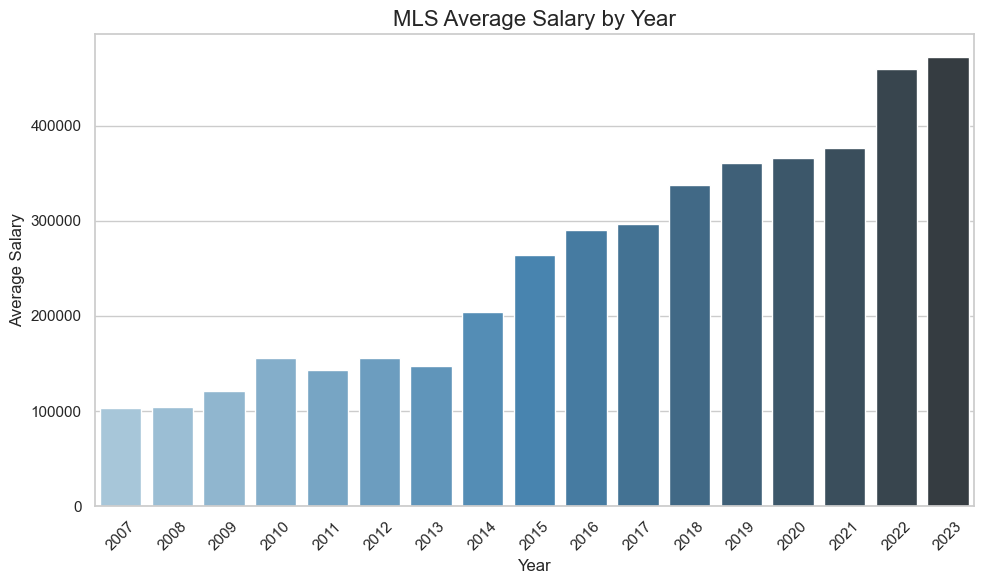

In [21]:
# Calculate the average salary for each year
average_salary_by_year = mls_salaries_df.groupby('year')['base_salary'].mean()


# Set the style using seaborn
sns.set(style="whitegrid")

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=average_salary_by_year.index, y=average_salary_by_year.values, palette="Blues_d")
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('MLS Average Salary by Year', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

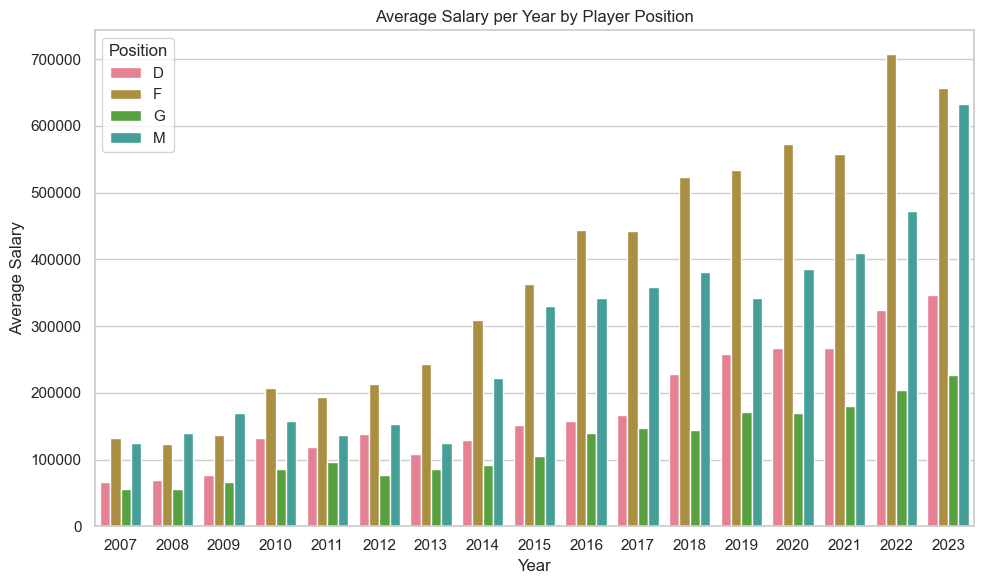

In [22]:
# Calculate average salary per year and position
average_salary = mls_salaries_df.groupby(['year', 'position'])['base_salary'].mean().reset_index()

# Pivot table to reshape the data
pivot_table = average_salary.pivot_table(index='year', columns='position', values='base_salary', fill_value=0)

# Reshape the data using melt
melted_data = average_salary.melt(id_vars=['year', 'position'], value_vars='base_salary', var_name='Metric', value_name='Average Salary')

# Stacked bar graph using seaborn
plt.figure(figsize=(10, 6))
sns.set_palette('husl')
sns.barplot(data=melted_data, x='year', y='Average Salary', hue='position')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Average Salary per Year by Player Position')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

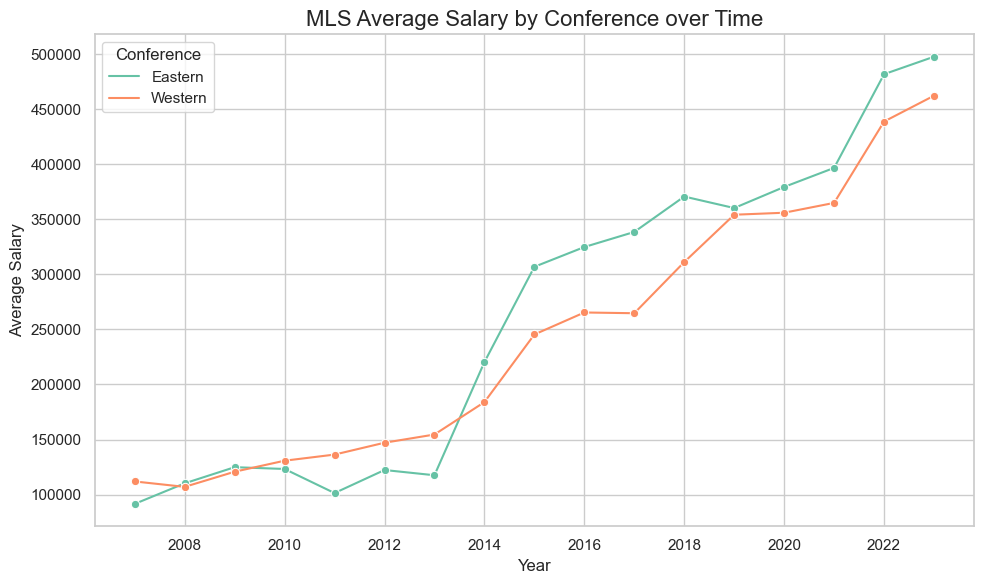

In [23]:
average_salary_by_region_year = mls_salaries_df.groupby(['conference', 'year'])['base_salary'].mean().reset_index()

# Set the style using seaborn
sns.set(style="whitegrid")

# Create the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_salary_by_region_year, x='year', y='base_salary', hue='conference', palette='Set2', marker='o')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('MLS Average Salary by Conference over Time', fontsize=16)
plt.legend(title='Conference')
plt.tight_layout()

plt.show()

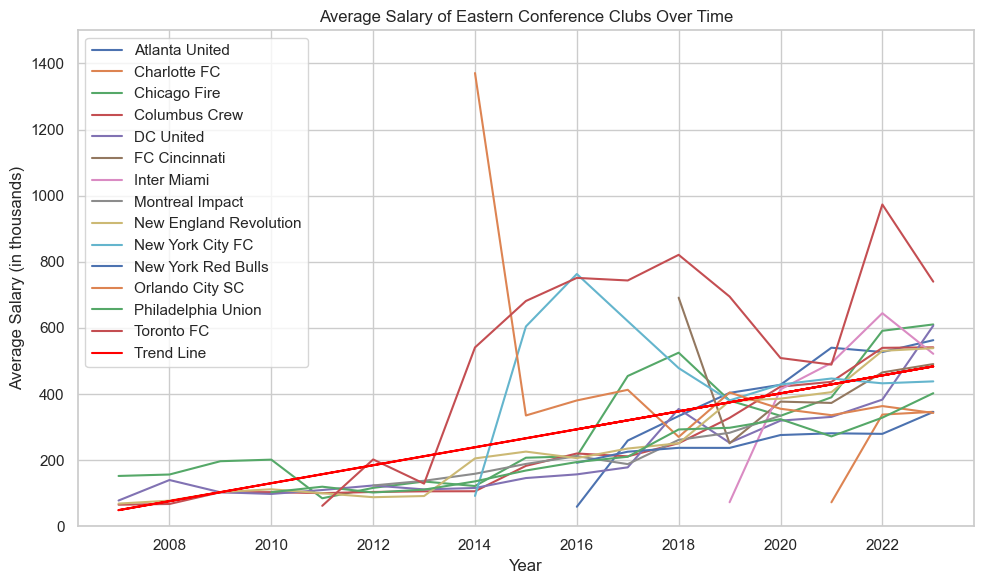

In [24]:

# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Eastern']

# Calculate yearly average salary for each club
average_salary = eastern_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

# Line graph with trend line
plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Eastern Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()

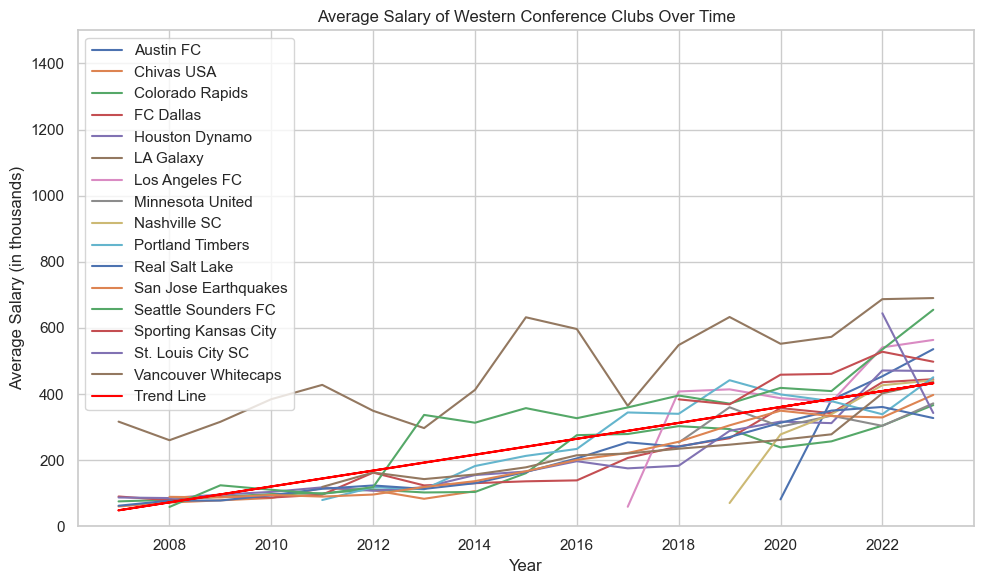

In [25]:
# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Western']

# Calculate yearly average salary for each club
average_salary = eastern_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

# Line graph with trend line
plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Western Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()

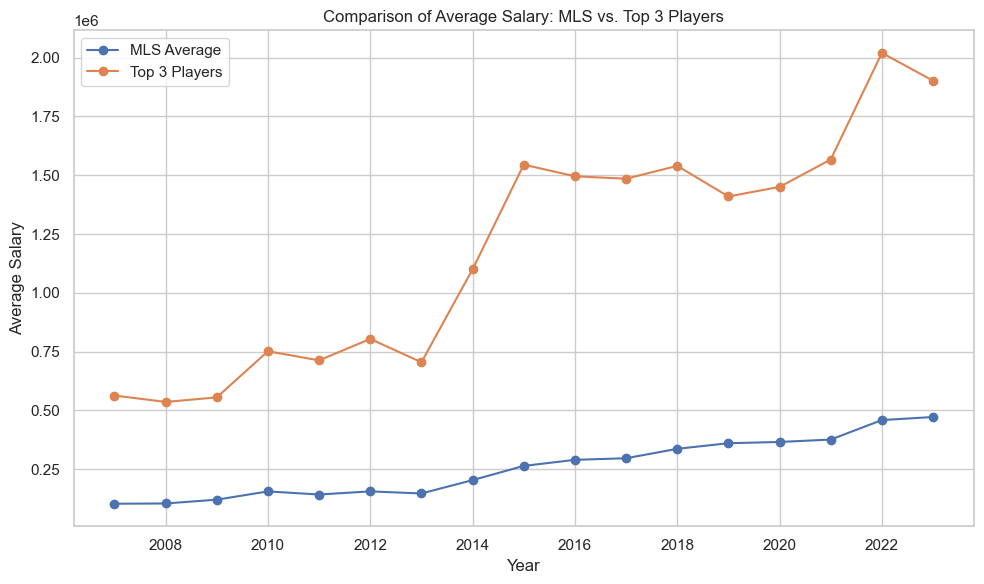

In [26]:
# Calculate average salary per year for the MLS
average_salary_mls = mls_salaries_df.groupby('year')['base_salary'].mean().reset_index()

# Calculate average salary per year for the top 3 players of each club
top_3_players = mls_salaries_df.groupby(['year', 'club']).apply(lambda x: x.nlargest(3, 'base_salary')).reset_index(drop=True)
average_salary_top_3 = top_3_players.groupby('year')['base_salary'].mean().reset_index()

# Line graph
plt.figure(figsize=(10, 6))
plt.plot(average_salary_mls['year'], average_salary_mls['base_salary'], marker='o', label='MLS Average')
average_salary_mls['base_salary'] /= 1_000_000
plt.plot(average_salary_top_3['year'], average_salary_top_3['base_salary'], marker='o', label='Top 3 Players')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Comparison of Average Salary: MLS vs. Top 3 Players')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
average_salary_top_3['base_salary'].fillna(method='ffill', inplace=True)
average_salary_top_3['year'] = pd.to_datetime(average_salary_top_3['year'], format='%Y')
average_salary_top_3.set_index('year', inplace=True)

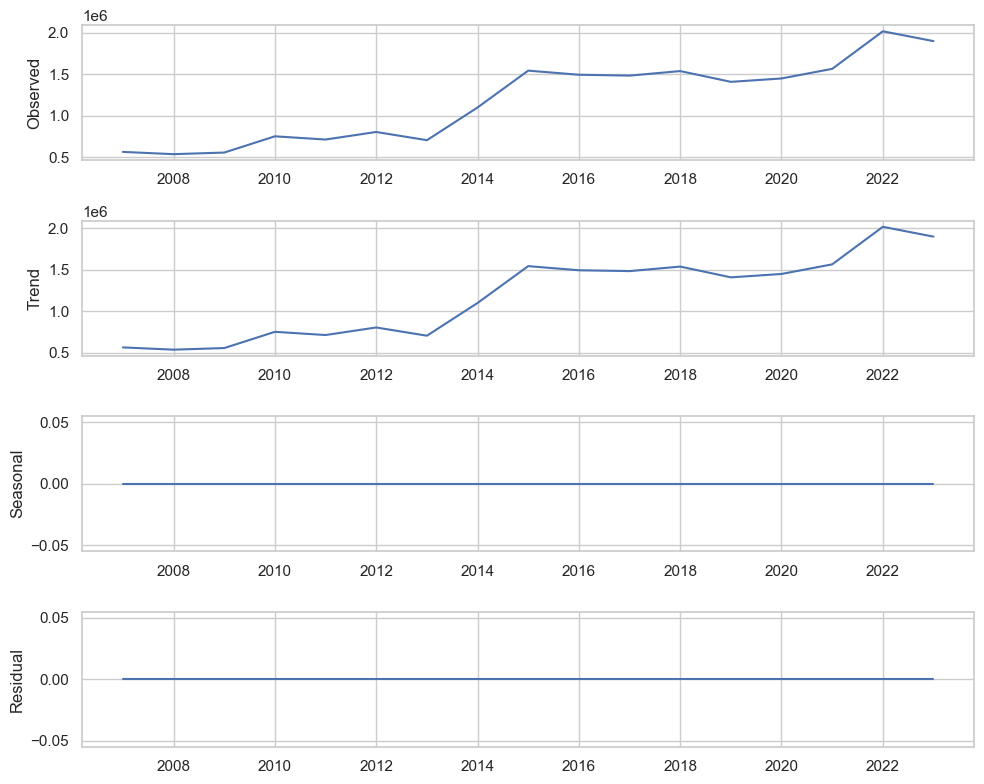

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(average_salary_top_3['base_salary'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(average_salary_top_3.index, decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(average_salary_top_3.index, decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(average_salary_top_3.index, decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(average_salary_top_3.index, decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

In [29]:
average_salary_mls['base_salary'].fillna(method='ffill', inplace=True)
average_salary_mls['year'] = pd.to_datetime(average_salary_mls['year'], format='%Y')
average_salary_mls.set_index('year', inplace=True)

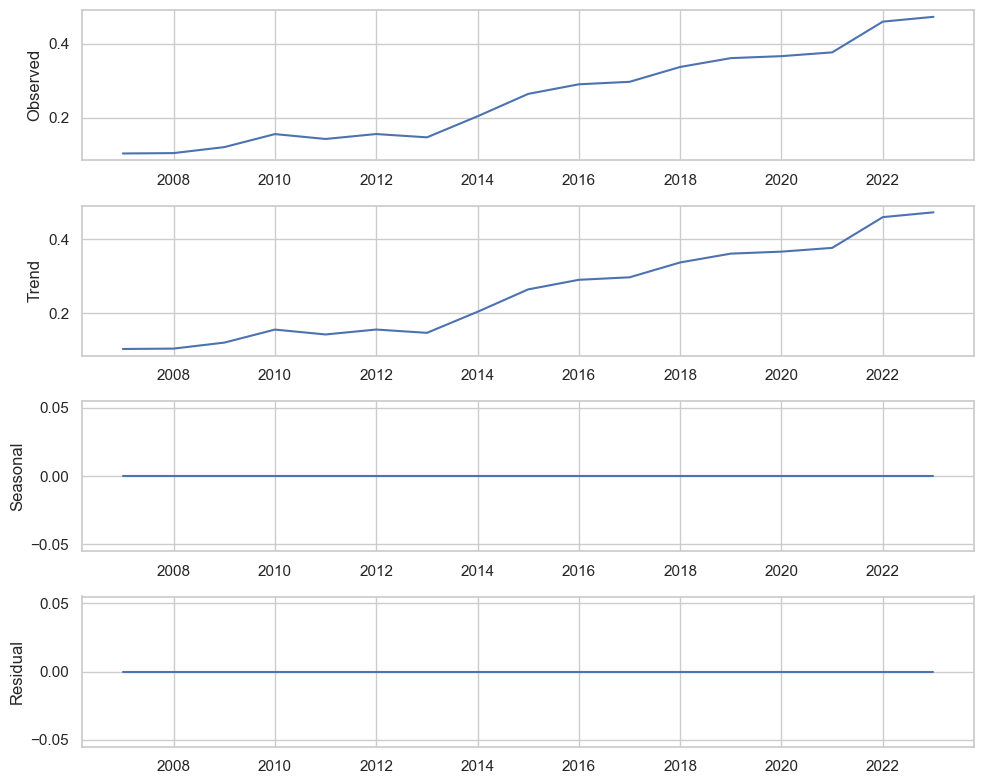

In [30]:
# Decompose the time series
decomposition = seasonal_decompose(average_salary_mls['base_salary'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(average_salary_mls.index, decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(average_salary_mls.index, decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(average_salary_mls.index, decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(average_salary_mls.index, decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Step 1: Split the Data
train_data = average_salary_mls.loc['2000':'2019']
test_data = average_salary_mls.loc['2020':]

# Step 2: Select Evaluation Metric
eval_metric = mean_squared_error

# Step 3: Choose Models
models = {
    'ARIMA': ARIMA(endog=train_data['base_salary'], order=(1, 1, 1)),
    'SARIMA': SARIMAX(train_data['base_salary'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

In [32]:
# Step 4: Train and Evaluate Models
results = {}
for model_name, model in models.items():
    if model_name == 'ARIMA':
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=len(test_data))
        predictions = forecast.predicted_mean
    elif model_name == 'SARIMA':
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    else:
        model.fit(train_data.index.values.astype(float).reshape(-1, 1), train_data['base_salary'])
        predictions = model.predict(test_data.index.values.astype(float).reshape(-1, 1))
    error = eval_metric(test_data['base_salary'], predictions)
    results[model_name] = error

# Step 5: Compare and Select Best Model
best_model = min(results, key=results.get)
best_error = results[best_model]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


In [33]:

# Step 6: Further Analysis

# Step 7: Finalize and Validate

# Print results
print("Model Comparison Results:")
for model, error in results.items():
    print(f"{model}: {error:.6f}")

print(f"\nBest Model: {best_model}")
print(f"Best Error: {best_error:.6f}")

Model Comparison Results:
ARIMA: 0.000764
SARIMA: 0.001843
Linear Regression: 0.001055
Random Forest: 0.006888

Best Model: ARIMA
Best Error: 0.000764


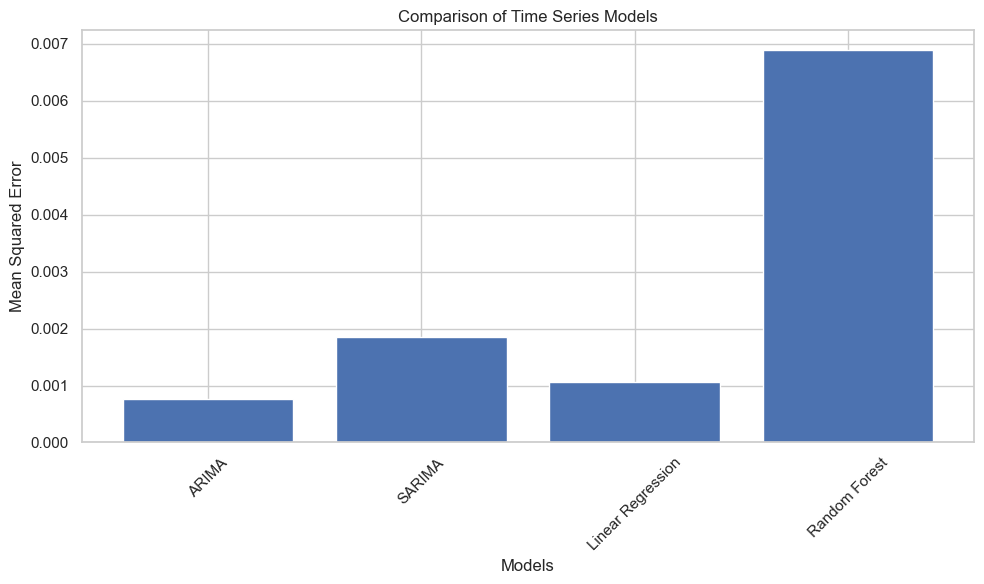

In [34]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Time Series Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Step 1: Split the Data
train_data = average_salary_top_3.loc['2000':'2019']
test_data = average_salary_top_3.loc['2020':]

# Step 2: Select Evaluation Metric
eval_metric = mean_squared_error

# Step 3: Choose Models
models = {
    'ARIMA': ARIMA(endog=train_data['base_salary'], order=(1, 1, 1)),
    'SARIMA': SARIMAX(train_data['base_salary'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

In [36]:
# Step 4: Train and Evaluate Models
results = {}
for model_name, model in models.items():
    if model_name == 'ARIMA':
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=len(test_data))
        predictions = forecast.predicted_mean
    elif model_name == 'SARIMA':
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    else:
        model.fit(train_data.index.values.astype(float).reshape(-1, 1), train_data['base_salary'])
        predictions = model.predict(test_data.index.values.astype(float).reshape(-1, 1))
    error = eval_metric(test_data['base_salary'], predictions)
    results[model_name] = error

# Step 5: Compare and Select Best Model
best_model = min(results, key=results.get)
best_error = results[best_model]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


In [37]:
# Step 6: Further Analysis

# Step 7: Finalize and Validate

# Print results
print("Model Comparison Results:")
for model, error in results.items():
    print(f"{model}: {error:.6f}")

print(f"\nBest Model: {best_model}")
print(f"Best Error: {best_error:.6f}")

Model Comparison Results:
ARIMA: 180128098000.660614
SARIMA: 81844877841.508789
Linear Regression: 36962840262.209747
Random Forest: 138911978954.382263

Best Model: Linear Regression
Best Error: 36962840262.209747


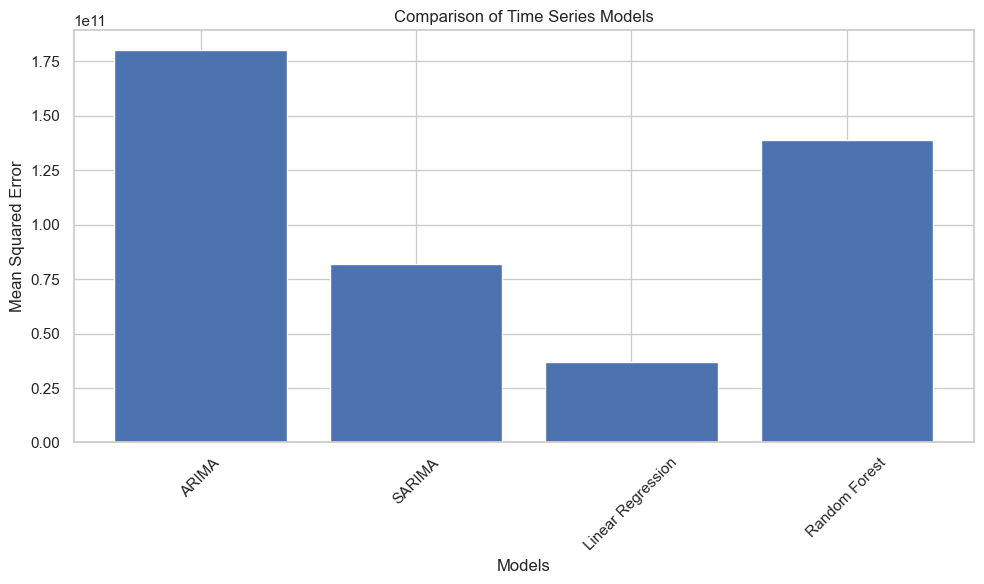

In [38]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Time Series Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(mls_salaries_df)

#Saving results to HTML file
sweet_report.show_html('MLS_salary_report.html')

/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  f

Report MLS_salary_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [44]:
# %pip install pandas_profiling  # Run this from Jupytor notebook Ignore the warnings if any 
from pandas_profiling import ProfileReport #restart the kernel if throws error
ProfileReport(mls_salaries_df)  

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
ProfileReport(top_3_players)  

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]